In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [120]:
epoch_ct = 50
batch_size = 86

In [121]:
MNIST_TRAIN_DIR = os.getcwd() + '/mnist_train.csv'
MNIST_TEST_DIR = os.getcwd() + '/mnist_test.csv'

def ImportMNISTDataFromDirectory(train_dir, test_dir):
    mnist_test = pd.read_csv(test_dir)
    mnist_train = pd.read_csv(train_dir)

    Xt_df = mnist_test.drop(['label'], axis=1)
    yt_df = mnist_test.label
    Xr_df = mnist_train.drop(['label'], axis=1)
    yr_df = mnist_train.label
    return Xt_df, yt_df, Xr_df, yr_df

In [122]:
Xt_df, yt_df, Xr_df, yr_df = ImportMNISTDataFromDirectory(MNIST_TRAIN_DIR, MNIST_TEST_DIR)

X_r = Xr_df.values.reshape(-1, 28, 28, 1)
X_t = Xt_df.values.reshape(-1, 28, 28, 1)
y_r = tf.keras.utils.to_categorical(yr_df, num_classes=10)
y_t = tf.keras.utils.to_categorical(yt_df, num_classes=10)


In [123]:
rescale_data = keras.Sequential([keras.layers.Rescaling(1/255.)])
X_r, X_v, y_r, y_v = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

train_ds = tf.data.Dataset.from_tensor_slices((X_r, y_r))
vald_ds = tf.data.Dataset.from_tensor_slices((X_v, y_v))
test_ds = tf.data.Dataset.from_tensor_slices((X_t, y_t))

train_ds = train_ds.map(lambda x, y: (rescale_data(x), y)).shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
vald_ds = vald_ds.map(lambda x, y: (rescale_data(x), y)).shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (rescale_data(x), y)).shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [124]:
model = keras.models.Sequential([
    # Image Convolution and downsampling - Node 1
    keras.layers.Conv2D(input_shape=(28,28,1), filters=64, kernel_size=3, padding='same', activation='relu'),
    # keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2, padding='same'),
    # Image Convolution and downsampling - Node 2
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    # keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2, padding='same'),
    # Image Convolution and downsampling - Node 3
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    # keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2, padding='same'),
    # Reduce to 1-D vector
    keras.layers.Flatten(),
    # Analysis using DNNs 
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_159 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_82 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_160 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_83 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_161 (Conv2D)         (None, 7, 7, 128)         147584    
                                                                 
 max_pooling2d_84 (MaxPooli  (None, 4, 4, 128)       

In [125]:
lr_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=2,
    min_lr=0.0000001
)

hist = model.fit(
    train_ds,
    validation_data = vald_ds,
    epochs = epoch_ct,
    callbacks=[lr_reduction],
    shuffle=True,
)

Epoch 1/50
559/559 [==============================] - 34s 61ms/step - loss: 0.1556 - accuracy: 0.9506 - val_loss: 0.0555 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 2/50
559/559 [==============================] - 31s 56ms/step - loss: 0.0434 - accuracy: 0.9862 - val_loss: 0.0447 - val_accuracy: 0.9866 - lr: 0.0010
Epoch 3/50
559/559 [==============================] - 33s 58ms/step - loss: 0.0284 - accuracy: 0.9909 - val_loss: 0.0488 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 4/50
559/559 [==============================] - 33s 59ms/step - loss: 0.0209 - accuracy: 0.9935 - val_loss: 0.0343 - val_accuracy: 0.9902 - lr: 0.0010
Epoch 5/50
559/559 [==============================] - 33s 60ms/step - loss: 0.0164 - accuracy: 0.9946 - val_loss: 0.0396 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 6/50
559/559 [==============================] - 34s 60ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.0526 - val_accuracy: 0.9880 - lr: 0.0010
Epoch 7/50
559/559 [==============================] - 32s 

In [130]:
future = model.evaluate(test_ds, verbose=2)
future[1]

117/117 - 2s - loss: 0.0309 - accuracy: 0.9944 - 2s/epoch - 19ms/step


0.9944000244140625

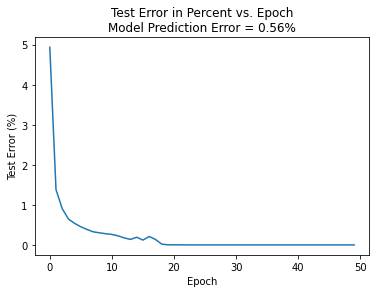

In [133]:
x = np.array(hist.epoch)
y = np.array(hist.history['accuracy'])
y = np.multiply(np.subtract(1, y), 100)
plt.plot(x, y)
plt.title(f'Test Error in Percent vs. Epoch\nModel Prediction Error = {(1-future[1])*100:.2f}%')
plt.xlabel('Epoch')
plt.ylabel('Test Error (%)')
plt.show()